In [31]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import kagglehub

# Download latest path
path = kagglehub.dataset_download("waqi786/remote-work-and-mental-health")

csv_file_path = f"{path}/Impact_of_Remote_Work_on_Mental_Health.csv"

# Load the dataset
data = pd.read_csv(csv_file_path)

data.head()

,Employee_ID,Age,Gender,Job_Role,Industry,Years_of_Experience,Work_Location,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,Stress_Level,Mental_Health_Condition,Access_to_Mental_Health_Resources,Productivity_Change,Social_Isolation_Rating,Satisfaction_with_Remote_Work,Company_Support_for_Remote_Work,Physical_Activity,Sleep_Quality,Region
0,EMP0001,32,Non-binary,HR,Healthcare,13,Hybrid,47,7,2,Medium,Depression,No,Decrease,1,Unsatisfied,1,Weekly,Good,Europe
1,EMP0002,40,Female,Data Scientist,IT,3,Remote,52,4,1,Medium,Anxiety,No,Increase,3,Satisfied,2,Weekly,Good,Asia
2,EMP0003,59,Non-binary,Software Engineer,Education,22,Hybrid,46,11,5,Medium,Anxiety,No,No Change,4,Unsatisfied,5,NaN,Poor,North America
3,EMP0004,27,Male,Software Engineer,Finance,20,Onsite,32,8,4,High,Depression,Yes,Increase,3,Unsatisfied,3,NaN,Poor,Europe
4,EMP0005,49,Male,Sales,Consulting,32,Onsite,35,12,2,High,NaN,Yes,Decrease,3,Unsatisfied,3,Weekly,Average,North America


**Preprocessing the Data**

We focus on extracting relevant features, handling missing data, and encoding categorical variables into numerical values. These transformations ensure the data is compatible with machine learning models.

In [23]:
# Preprocessing: Filter necessary columns and handle missing data
features = [
    "Work_Location", "Age", "Gender", "Job_Role", "Hours_Worked_Per_Week",
    "Industry", "Mental_Health_Condition", "Work_Life_Balance_Rating", "Productivity_Change"
]
data = data[features].dropna()  # Drop rows with missing values
data = pd.get_dummies(data, columns=["Gender", "Job_Role", "Industry"], drop_first=True)

# Encode Work_Location (Target Variable)
location_mapping = {"Onsite": 0, "Hybrid": 1, "Remote": 2}
data["Work_Location"] = data["Work_Location"].map(location_mapping)

# Encode Mental_Health_Condition
le = LabelEncoder()
data["Mental_Health_Condition"] = le.fit_transform(data["Mental_Health_Condition"].astype(str))

# Encode Productivity_Change
productivity_mapping = {"Increase": 1, "No Change": 0, "Decrease": -1}
data["Productivity_Change"] = data["Productivity_Change"].map(productivity_mapping)

We use one-hot encoding for categorical features like gender, job role, and industry. The target variable (Work_Location) is mapped to numerical values for classification.
- 0 - Onsite
- 1 - Hybrid
- 2 - Remote

Similarly, we also map the Productivity_Change values to numerical values for classification.

**Creating Company Samples**

Since the goal is to predict the optimal work model for companies, we create samples of 10 employees to represent individual companies. This helps simulate real-world scenarios where decisions are made at the company level.

In [24]:
# Create random samples of 10 employees per company
def create_company_samples(df, sample_size=10):
    companies = []
    while len(df) >= sample_size:
        sample = df.sample(sample_size)
        df = df.drop(sample.index)
        companies.append(sample)
    return companies

companies = create_company_samples(data, sample_size=10)

Here, we generate multiple company samples, each consisting of 10 employees from the dataset.

**Aggregating Data for Each Company**

We compute aggregate statistics (e.g., mean values) for numerical features within each company. The target variable is determined by the majority work model label among the 10 employees.

In [25]:
# Aggregate data for each company
company_features = []
company_labels = []

for company in companies:
    # Aggregate numeric features only
    numeric_features = company.drop(columns=["Work_Location"]).select_dtypes(include=['number']).mean().to_dict()

    # Determine the majority work location
    majority_label = company["Work_Location"].mode()[0]

    company_features.append(numeric_features)
    company_labels.append(majority_label)

# Convert features and labels to DataFrame and NumPy array
X = pd.DataFrame(company_features)
y = np.array(company_labels)

This step reduces the dimensionality of the data and ensures each company is represented by a single record.

**Splitting Data and Training the Model**

We split the aggregated data into training and testing sets, train a Random Forest classifier, and evaluate its performance.

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Model Performance:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Model Performance:
              precision    recall  f1-score   support

           0       0.37      0.39      0.38        28
           1       0.31      0.38      0.34        21
           2       0.45      0.33      0.38        27

    accuracy                           0.37        76
   macro avg       0.37      0.37      0.37        76
weighted avg       0.38      0.37      0.37        76

Accuracy: 0.3684210526315789


Random Forest is chosen for its ability to handle both classification tasks and complex interactions between features. The evaluation metrics include accuracy and a detailed classification report.

**Predicting the Optimal Work Model**

Finally, we create a function to predict the best work model for a new company based on varying the Work_Location parameter. This function simulates the scenario of testing different work models for a given workforce.

In [29]:
# Get the list of features used for training
feature_columns = X_train.columns

# Function to predict optimal work model for a new company
def recommend_work_model(new_company_data, model):
    locations = ["Onsite", "Hybrid", "Remote"]
    results = {}
    for location in locations:
        temp_data = new_company_data.copy()
        temp_data["Work_Location"] = location_mapping[location]

        # Aggregate features and ensure alignment with training data
        temp_features = pd.DataFrame([temp_data.mean()], columns=feature_columns).fillna(0)

        # Predict work model
        result = model.predict(temp_features)[0]
        results[location] = result
    return max(results, key=results.get)

# Simulating a new company input
new_company = companies[0].drop(columns="Work_Location")  # Use one of the existing samples
optimal_model = recommend_work_model(new_company, model)
print(f"Recommended Work Model for the new company: {optimal_model}")

Recommended Work Model for the new company: Onsite


Accuracy: 0.37
Classification Report:
              precision    recall  f1-score   support

      Onsite       0.37      0.39      0.38        28
      Hybrid       0.31      0.38      0.34        21
      Remote       0.45      0.33      0.38        27

    accuracy                           0.37        76
   macro avg       0.37      0.37      0.37        76
weighted avg       0.38      0.37      0.37        76

Confusion Matrix:
[[11 10  7]
 [ 9  8  4]
 [10  8  9]]


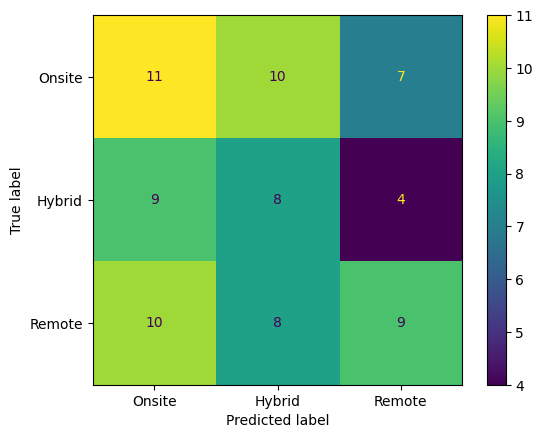

In [32]:
# Evaluate the model with additional metrics
y_pred = model.predict(X_test)

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=["Onsite", "Hybrid", "Remote"])
print("Classification Report:")
print(report)

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
print(cm)

# Plot confusion matrix (if running in an environment that supports plots)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Onsite", "Hybrid", "Remote"])
disp.plot(cmap="viridis")